# Getting Data from Twitter

In [0]:
# Variables that contains the user credentials to access Twitter API 
access_token = '960417619-RZ7ufPidlh0aUZLpqXQfD054yb4dpOdfp05zKMZH'     # PLEASE USE YOUR OWN
access_token_secret = 'woP1ILbfrJ4bTQtYQOOqVIIxUOAJ2mwWomrL1MyiDQBIq'   # PLEASE USE YOUR OWN
consumer_key = 'S0NaTfqhbRZf0gtMqiOUWBWGZ'                              # PLEASE USE YOUR OWN
consumer_secret = '468JrH5g4Gmo1aPHGugRGvY7YXjl9RXiOOpDW0MBPAwRWKBrr4'  # PLEASE USE YOUR OWN

In [2]:
!pip install tweepy

In [0]:
# https://bhaskarvk.github.io/2015/01/how-to-use-twitters-search-rest-api-most-effectively./

import tweepy
from tweepy import OAuthHandler,AppAuthHandler,API

auth = AppAuthHandler(consumer_key, consumer_secret)
# auth.set_access_token(access_token, access_token_secret)

# api = tweepy.API(auth)
api = API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

**Inporting General Dependencies**

In [0]:
import json, time, csv, re
import pandas as pd
import numpy as np



**Mounting Google Drive**

In [5]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


**Declaring Folder Paths**

In [0]:
DATA_FILEPATH = '/content/drive/My Drive/BT4222 Data/'
TWEETS_FILEPATH = 'tweets_data/'

## Reading Company Data

Reads in the company historical data and stock prices that have been generated from Yahoo Finance

In [0]:
# Read Company Index Names from xlsx file
INDEXNAME_FILENAME = 'Tech Stock List.xlsx'

df_index_name = pd.read_excel(DATA_FILEPATH + INDEXNAME_FILENAME, sheet_name='Tech Co Symbols')
print(df_index_name.columns)

Index(['Symbol', 'Name', 'IPOyear', 'Sector', 'Industry', 'Summary Quote'], dtype='object')


In [0]:
# Removes unidentifiable information and spaces from Company Name 
replacements = [' ', ',', 'Inc.', 'Ltd.', 'Corp.', 'Limited']
for r in replacements:
    df_index_name['Name'] = df_index_name['Name'].str.replace(r,'')

df_index_name.shape

(617, 6)

In [0]:
df_index_name.head(10)

,Symbol,Name,IPOyear,Sector,Industry,Summary Quote
0,VNET,21VianetGroup,2011.0,Technology,"Computer Software: Programming, Data Processing",https://www.nasdaq.com/symbol/vnet
1,TWOU,2U,2014.0,Technology,Computer Software: Prepackaged Software,https://www.nasdaq.com/symbol/twou
2,DDD,3DSystemsration,NaN,Technology,Computer Software: Prepackaged Software,https://www.nasdaq.com/symbol/ddd
3,JOBS,51job,2004.0,Technology,Diversified Commercial Services,https://www.nasdaq.com/symbol/jobs
4,WUBA,58.com,2013.0,Technology,"Computer Software: Programming, Data Processing",https://www.nasdaq.com/symbol/wuba
5,EGHT,8x8Inc,NaN,Technology,EDP Services,https://www.nasdaq.com/symbol/eght
6,ATEN,A10Networks,2014.0,Technology,Computer Communications Equipment,https://www.nasdaq.com/symbol/aten
7,AAN,Aaron&#39;s,NaN,Technology,Diversified Commercial Services,https://www.nasdaq.com/symbol/aan
8,ACIA,AcaciaCommunications,2016.0,Technology,Semiconductors,https://www.nasdaq.com/symbol/acia
9,ACIW,ACIWorldwide,NaN,Technology,Computer Software: Prepackaged Software,https://www.nasdaq.com/symbol/aciw



## **Scraping Twitter Data**

Input: Company Name, Symbol Name, Start Date and End Date of scraping period

Output: Symbol Name



In [0]:
## Function to scrape Twitter data and writ e/append to the respective JSON file for each company
# https://developer.twitter.com/en/docs/tweets/search/api-reference/get-search-tweets.html

# TWEETDATA_FILENAME = 'scraped_tweets_data.json'
def scrape_tweets(company_name, symbol_name, start_date, end_date):
    print('Begin Scraping')
    start = time.time()

    query = "#{company_name} OR @{symbol_name} -filter:retweets".format(company_name=company_name, symbol_name=symbol_name) 
    max_tweets = 100000
    print("Twitter API Query:", query)
    
    searched_tweets = []
    last_id = -1
    while len(searched_tweets) < max_tweets:
        count = max_tweets - len(searched_tweets)
        try:
            new_tweets = api.search(q=query, lang='en', since=start_date, until=end_date, count=count, max_id=str(last_id - 1), tweet_mode = "extended")
            if not new_tweets:
                break
            searched_tweets.extend(new_tweets)
            last_id = new_tweets[-1].id
        except tweepy.TweepError as e:
            print('Error:', e)
            return symbol_name

    end = time.time()
    print("Scraping has completed")
    print("Time taken: ", end - start, 's')
    print("Number of Tweets scraped:", len(searched_tweets))
    
    # Do not continue and update JSON file if no tweets have been scraped
    if len(searched_tweets) == 0:
      print('\n')
      return symbol_name
    
    # Convert all the results into a `list of dictionaries`
    list_of_status_dicts_2 = [x._json for x in searched_tweets]
    
    
    data = {"tweets": []}
    # Attempts to read data from json file
    # TWEETDATA_FILENAME = 'Tweets Data/' + symbol_name + '.json'
    TWEETDATA_FILENAME = TWEETS_FILEPATH + symbol_name + '.json'
    try:
        # Reads in existing tweets data 
        with open(DATA_FILEPATH + TWEETDATA_FILENAME) as f:
            data = json.load(f)
        print("Read data successfully from:", TWEETDATA_FILENAME)
            
    except FileNotFoundError as e:
        # Create a new JSON file
        with open(DATA_FILEPATH + TWEETDATA_FILENAME, mode='w', encoding='utf-8') as f:
            json.dump(data, f)
        print("Created new JSON file:", TWEETDATA_FILENAME)
        
    finally:
        ### Write data to json file 
        # Appends the existing tweets data with new tweets data
        data['tweets'].extend(list_of_status_dicts_2)
        # Updates the JSON file
        with open(DATA_FILEPATH + TWEETDATA_FILENAME, 'w') as f:
            json.dump(data, f)
        print("Updated tweets successfully")
    
    print('\n')
    return symbol_name;


In [0]:
# First Scraped Period: "2019-02-14" to "2019-02-25"
# Second Scraped Period: "2019-02-26" to "2019-03-05"
# Third Scraped Period: "2019-03-05" to "2019-03-11"
# Forth Scraped Period: "2019-03-12" to "2019-03-18"
# Fifth Scraped Period: "2019-03-19" to "2019-03-27"
# Sixth Scraped Period: "2019-03-27" to "2019-04-01"
# Total number of days scraped: 46 Days

start_date = "2019-03-27"
end_date = "2019-04-01"
df_index_name.apply(lambda row: scrape_tweets(row['Name'], str(row['Symbol']), start_date, end_date), axis=1)

Begin Scraping
Twitter API Query: #21VianetGroup OR @VNET -filter:retweets
Scraping has completed
Time taken:  0.1528339385986328 s
Number of Tweets scraped: 0


Begin Scraping
Twitter API Query: #2U OR @TWOU -filter:retweets
Scraping has completed
Time taken:  0.2800161838531494 s
Number of Tweets scraped: 4
Read data successfully from: tweets_data/TWOU.json
Updated tweets successfully


Begin Scraping
Twitter API Query: #3DSystemsration OR @DDD -filter:retweets
Scraping has completed
Time taken:  0.14364147186279297 s
Number of Tweets scraped: 0


Begin Scraping
Twitter API Query: #51job OR @JOBS -filter:retweets
Scraping has completed
Time taken:  0.3796572685241699 s
Number of Tweets scraped: 3
Read data successfully from: tweets_data/JOBS.json
Updated tweets successfully


Begin Scraping
Twitter API Query: #58.com OR @WUBA -filter:retweets
Scraping has completed
Time taken:  0.4047825336456299 s
Number of Tweets scraped: 25
Read data successfully from: tweets_data/WUBA.json
Update

Rate limit reached. Sleeping for: 542


Scraping has completed
Time taken:  547.4559600353241 s
Number of Tweets scraped: 12
Read data successfully from: tweets_data/CLS.json
Updated tweets successfully


Begin Scraping
Twitter API Query: #CeragonNetworks OR @CRNT -filter:retweets
Scraping has completed
Time taken:  0.1678309440612793 s
Number of Tweets scraped: 0


Begin Scraping
Twitter API Query: #CeridianHCMHolding OR @CDAY -filter:retweets
Scraping has completed
Time taken:  0.11271142959594727 s
Number of Tweets scraped: 0


Begin Scraping
Twitter API Query: #Cernerration OR @CERN -filter:retweets
Scraping has completed
Time taken:  1.711909294128418 s
Number of Tweets scraped: 332
Read data successfully from: tweets_data/CERN.json
Updated tweets successfully


Begin Scraping
Twitter API Query: #CEVA OR @CEVA -filter:retweets
Scraping has completed
Time taken:  0.2693140506744385 s
Number of Tweets scraped: 1
Read data successfully from: tweets_data/CEVA.json
Updated tweets successfully


Begin Scraping
Twitter API Que

Rate limit reached. Sleeping for: 605


Scraping has completed
Time taken:  617.2795217037201 s
Number of Tweets scraped: 1940
Read data successfully from: tweets_data/IBM.json
Updated tweets successfully


Begin Scraping
Twitter API Query: #InternetInitiativeJapan OR @IIJI -filter:retweets
Scraping has completed
Time taken:  0.19982671737670898 s
Number of Tweets scraped: 0


Begin Scraping
Twitter API Query: #InterpublicGroupofCompanies(The) OR @IPG -filter:retweets
Scraping has completed
Time taken:  0.16576552391052246 s
Number of Tweets scraped: 0


Begin Scraping
Twitter API Query: #InterXionHoldingN.V. OR @INXN -filter:retweets
Scraping has completed
Time taken:  0.17384696006774902 s
Number of Tweets scraped: 0


Begin Scraping
Twitter API Query: #Intevac OR @IVAC -filter:retweets
Scraping has completed
Time taken:  0.12145280838012695 s
Number of Tweets scraped: 0


Begin Scraping
Twitter API Query: #Intuit OR @INTU -filter:retweets
Scraping has completed
Time taken:  0.7102437019348145 s
Number of Tweets scraped: 7

Rate limit reached. Sleeping for: 682


Scraping has completed
Time taken:  692.0624997615814 s
Number of Tweets scraped: 962
Read data successfully from: tweets_data/SNAP.json
Updated tweets successfully


Begin Scraping
Twitter API Query: #SocialReality OR @SRAX -filter:retweets
Scraping has completed
Time taken:  0.24851727485656738 s
Number of Tweets scraped: 2
Read data successfully from: tweets_data/SRAX.json
Updated tweets successfully


Begin Scraping
Twitter API Query: #SocketMobile OR @SCKT -filter:retweets
Scraping has completed
Time taken:  0.2728450298309326 s
Number of Tweets scraped: 1
Created new JSON file: tweets_data/SCKT.json
Updated tweets successfully


Begin Scraping
Twitter API Query: #Sogou OR @SOGO -filter:retweets
Scraping has completed
Time taken:  0.13576006889343262 s
Number of Tweets scraped: 0


Begin Scraping
Twitter API Query: #Sohu.com OR @SOHU -filter:retweets
Scraping has completed
Time taken:  0.4210324287414551 s
Number of Tweets scraped: 53
Read data successfully from: tweets_data/SOHU.

0      VNET
1      TWOU
2       DDD
3      JOBS
4      WUBA
5      EGHT
6      ATEN
7       AAN
8      ACIA
9      ACIW
10     ACMR
11     ATVI
12      ATU
13     IOTS
14     ADBE
15      AMD
16      AER
17      ACY
18     HIVE
19     AGYS
20     AGMH
21       AL
22      AYR
23     AIRG
24     AMCN
25     ALRM
26     ALYA
27     ALLT
28     MDRX
29     AOSL
       ... 
587    VSAT
588    VIAV
589    VRTU
590     VMW
591    VISI
592    VUZI
593    WSTG
594      WB
595     WBT
596     WDC
597     WYY
598     WIT
599     WIX
600    WDAY
601      WK
602     WPP
603     XRX
604    XLNX
605    XPER
606    XNET
607    YNDX
608    YEXT
609      YY
610    ZBRA
611    ZDGE
612     ZEN
613    ZIXI
614      ZS
615     ZUO
616    ZNGA
Length: 617, dtype: object

# **Reading Data from JSON file in Google Drive**

In [7]:
# Look at items in the folder
import glob
# file_path = glob.glob(DATA_FILEPATH + TWEETS_FILEPATH + '*.json' )
file_paths = glob.glob(DATA_FILEPATH + TWEETS_FILEPATH + '*.json' )
len(file_paths)


448

First, we will read in the individual stock market's tweets from the JSON file.

We will then add 2 columns to the tweets DataFrame, namely, created_at and full_text. created_at column shows the date and time of the tweet and the  full_text column contains the tweet.

Finally, we will append the Symbol of the company index to the respective tweets.

In [0]:
# Function to read data from json file
def read_tweets_data(file_name, print_true):
  
  try:
    # Read in tweet data
    with open(DATA_FILEPATH + TWEETS_FILEPATH + file_name) as f:
        loaded_tweets_data = json.load(f)['tweets']

    # Convert to DataFrame
    tweets_data = pd.DataFrame()
    tweets_data['created_at'] = list(map(lambda tweet: tweet['created_at'] if 'created_at' in tweet else None, loaded_tweets_data))
    tweets_data['full_text'] = list(map(lambda tweet: tweet['full_text'] if 'full_text' in tweet else None, loaded_tweets_data))
    # Concat a column of company Symbol to tweets data
    tweets_data.insert(0, 'Symbol', file_name.split('.')[0]) # E.g. Splits from AAPL.json to AAPL
    if print_true:
      print(len(tweets_data))
    
  except FileNotFoundError as e:
    print("File Does not exist")
    raise e
    
  finally:
    return tweets_data

In [9]:
file_paths[0]

'/content/drive/My Drive/BT4222 Data/tweets_data/ATVI.json'

The tweets from each company will be combined into a DataFrame

In [10]:
# Reading of tweets data and appending to a dataframe
from random import randint 

# Read data from json file
loaded_tweets_data = []

# Iterate through each file to read in tweets
for file in file_paths:
  # Extract file name from file path (E.g. Extract 'TWOU.json' from '/content/drive/My Drive/BT4222 Data/Test Folder/TWOU.json')
  file_name = file.split('/')[-1]
  # Random Printing
  ran_num = randint(1,100)
  print_true = 0
  if ran_num > 85:
    print(file_name) 
    print_true = 1
  try:
    # Only for first time when list is empty
    if len(loaded_tweets_data) == 0:
      loaded_tweets_data = read_tweets_data(file_name, print_true)
    else: 
      # Appends to tweets that have been read in
      loaded_tweets_data = loaded_tweets_data.append(read_tweets_data(file_name, print_true))
  except FileNotFoundError as e:
    continue

# len(loaded_tweets_data)

MSTR.json
2
SPSC.json
2
TENB.json
2
CHKP.json
1
OSIS.json
1
CMTL.json
2
SWI.json
7
AMN.json
6
BLIN.json
3
HSTM.json
4
VECO.json
3
ALLT.json
10
AABA.json
11
AQ.json
17
ATHM.json
5
COUP.json
8
EMAN.json
15
MINDP.json
4
STM.json
29
SNX.json
1
JOBS.json
50
ADBE.json
13218
AMD.json
7039
PLAN.json
140
APY.json
10
ASML.json
16
JG.json
29
BNFT.json
15
CARS.json
2456
CREX.json
16
CY.json
44
CYRN.json
11
DMRC.json
17
DBX.json
1382
FB.json
136096
FIT.json
8940
FTNT.json
1301
GILT.json
63
GDDY.json
4905
HPE.json
2711
INOD.json
10
KELYA.json
23326
LN.json
33
LOGM.json
134
MIME.json
174
NATI.json
8
NTAP.json
1328
OOMA.json
149
PANW.json
283
PVTL.json
1
PNR.json
27
SFET.json
1
SHOP.json
10917
SCKT.json
1
SOHU.json
283
SSYS.json
109
SNPS.json
44
VERI.json
27
WB.json
134
YEXT.json
232
ZEN.json
180


In [11]:
# Check the number of unique Symbols read in
len(loaded_tweets_data.sort_values(by="Symbol").drop_duplicates(subset='Symbol'))
# len(loaded_tweets_data)

448

In [12]:
loaded_tweets_data.head()

,Symbol,created_at,full_text
0,ATVI,Sun Feb 24 20:26:57 +0000 2019,@atvi @Treyarch @charlieINTEL @CallofDuty @Sub...
1,ATVI,Sun Feb 24 20:26:57 +0000 2019,@atvi @Treyarch @charlieINTEL @CallofDuty @Sub...
0,AAOI,Fri Feb 22 14:55:07 +0000 2019,Literally watched it spiked thru $13 @AAOI to ...
1,AAOI,Fri Feb 22 14:55:07 +0000 2019,Literally watched it spiked thru $13 @AAOI to ...
0,BHE,Thu Feb 21 18:20:46 +0000 2019,Looking forward to getting a tour of the new @...


# **Sentiment Analysis**

## **Preparing Data**

In [0]:
# Expands display columns and width to show full text
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

Remove any duplicated tweets that have been scraped

In [14]:
# Remove duplicated tweets
no_dup_tweets_data = loaded_tweets_data.drop_duplicates(subset='full_text')
len(no_dup_tweets_data)

657826

created_at column will be converted to datetime datatype.

In [15]:
# Converts created_at column the datetime datatype
no_dup_tweets_data['created_at'] = pd.to_datetime(no_dup_tweets_data['created_at'])
no_dup_tweets_data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,Symbol,created_at,full_text
0,ATVI,2019-02-24 20:26:57,@atvi @Treyarch @charlieINTEL @CallofDuty @SubToOptimus @NerosCinema Due to team killing still being a thing in blackout the Only BR with team killing im done also your greedy little loot system is a disgrace clocked 3hr 21 min fOr 2 \nFAKING FACE PAINTS this is TRASH DO NOT BUY
0,AAOI,2019-02-22 14:55:07,Literally watched it spiked thru $13 @AAOI to $14.5 while trying to long at the open at $13 on my phone. This is sad.
0,BHE,2019-02-21 18:20:46,Looking forward to getting a tour of the new @BenchElec Tempe HQ later this week!\nRSP Architects 👉🏻 https://t.co/RVLlri7oqj\n#Benchmark #BenchmarkElectronics #Tempe #Arizona https://t.co/ZPW5bNoA8q
0,BDR,2019-02-22 03:40:42,@mySUKEofficial may we know why the construction at Bdr tasik selatan btw majulink/shell and Desa tun razak (@bdr tun razak) especially middle of the road few mths no work done/stop? Very jam. Structure none done. JAM teruk!!!
0,CYBR,2019-02-24 16:50:00,Cyberark Software (CYBR) Issues Q1 2019 Earnings Guidance https://t.co/TacLIWyoJ2 #cyberarksoftware #guidance #earnings @dailypoliticaln #bugbounty #bugbounties


Sort tweets in alphabetical order by Symbol then created_at in ascending order

In [0]:
# Sort tweets by ascending order
sorted_tweets_data = no_dup_tweets_data.sort_values(by=['Symbol', 'created_at']) 

Preview the tweets DataFrame

In [17]:
sorted_tweets_data.head()

,Symbol,created_at,full_text
2,AABA,2019-02-15 21:06:35,"#Altaba Inc. (#AABA) is #pricier while #VMware, Inc. (#VMW) is #cheap – #Post #Analyst https://t.co/7RtgTB1Hzi"
1,AABA,2019-02-20 11:33:09,#GeorgeSoros biggest #Investments\n#GCILiberty \n#CoupaSoftware \n#PhilipMorris \n#iSharesRussell1000ETF \n#Financial Select Sector #SPDRFund\n#MondelezInternational \n#Altaba \n#Caesars #Entertainment \n#Vici #Properties \n#Liberty #Broadband\nhttps://t.co/LXKNDcFpfF\n#Qanon #WWG1WGA #Q
0,AABA,2019-02-22 12:00:10,#Altaba $AABA BidaskScore is Increased to Held https://t.co/MDGDC9sWHX
6,AABA,2019-02-28 11:30:01,"#HedgeFund manager #PaulSinger's #ElliottManagement top sales of #Q42018, #Altaba Inc. #AABA https://t.co/bowgF5f8Fs"
8,AABA,2019-03-05 11:30:00,"#HedgeFund manager #PaulSinger's #ElliottManagement top sales of #Q42018, #Altaba Inc. #AABA https://t.co/bowgF4XxNU"


In [18]:
sorted_tweets_data.tail()

,Symbol,created_at,full_text
15,ZUO,2019-03-26 14:16:28,Looks like #Zuora #ZUO is dropping again today when the overall market is up. The bottom now seems more closer to $17. Bad time for poor earnings. #stocks\n\n@cnbc @msnbc @CNNMoneyInvest @business
14,ZUO,2019-03-26 15:22:49,@SkylineGrow @CanaccorGenuity I've been behind them for a long time now but keep getting smashed on ER. One day the sun will shine. I hope! $ZUO #Zuora
13,ZUO,2019-03-26 21:13:42,@theoldrepublic @CNBC @MSNBC @CNNMoneyInvest @business Complete disaster. Should've learned from the last 3 times I got smoked on their ER. This stock continues to pummel me $zuo #zuora
28,ZUO,2019-03-27 16:20:59,@Sarge986 I'm already getting pummeled by $zuo Pot committed. Might as well add to it #zuo #zuora
27,ZUO,2019-03-31 08:00:02,These are likely illegitimate #swpats but #zuora blags about them anyway. Just because #iancu -led #uspto grants fake #patents doesn't mean courts will respect these. https://t.co/GTXk7IFEeq


In [19]:
print('Start Date:', min(sorted_tweets_data['created_at']))
print('End Date:', max(sorted_tweets_data['created_at']))

Start Date: 2019-02-15 12:58:59
End Date: 2019-03-31 23:59:44


In [20]:
print('Total Number of Tweets: ', len(sorted_tweets_data))

Total Number of Tweets:  657826


In [21]:
sorted_tweets_data.head()

,Symbol,created_at,full_text
2,AABA,2019-02-15 21:06:35,"#Altaba Inc. (#AABA) is #pricier while #VMware, Inc. (#VMW) is #cheap – #Post #Analyst https://t.co/7RtgTB1Hzi"
1,AABA,2019-02-20 11:33:09,#GeorgeSoros biggest #Investments\n#GCILiberty \n#CoupaSoftware \n#PhilipMorris \n#iSharesRussell1000ETF \n#Financial Select Sector #SPDRFund\n#MondelezInternational \n#Altaba \n#Caesars #Entertainment \n#Vici #Properties \n#Liberty #Broadband\nhttps://t.co/LXKNDcFpfF\n#Qanon #WWG1WGA #Q
0,AABA,2019-02-22 12:00:10,#Altaba $AABA BidaskScore is Increased to Held https://t.co/MDGDC9sWHX
6,AABA,2019-02-28 11:30:01,"#HedgeFund manager #PaulSinger's #ElliottManagement top sales of #Q42018, #Altaba Inc. #AABA https://t.co/bowgF5f8Fs"
8,AABA,2019-03-05 11:30:00,"#HedgeFund manager #PaulSinger's #ElliottManagement top sales of #Q42018, #Altaba Inc. #AABA https://t.co/bowgF4XxNU"


In [24]:
temp_df = sorted_tweets_data.groupby('Symbol', as_index=False).agg({'full_text': 'count'})
temp_df.columns = ['Symbol', 'tweets_count']
temp_df.head()
len(temp_df[temp_df['tweets_count']<3])



84

In [25]:
sorted_tweets_data.isnull().sum()

Symbol        0
created_at    0
full_text     0
dtype: int64

Resources: https://www.datacamp.com/community/tutorials/simplifying-sentiment-analysis-python

## **Removing unwanted patterns in tweets **
Using regex to remove unwanted patterns in tweets
(E.g. Twitter handle, punctuations)

In [0]:
# Remove mentions/twitter handles. E.g. @abc
sorted_tweets_data['full_text'] = sorted_tweets_data['full_text'].apply(lambda x:' '.join(re.sub("(@[A-Za-z0-9]+)", " ", x).split()))

# Remove urls
sorted_tweets_data['full_text'] = sorted_tweets_data['full_text'].apply(lambda x:' '.join(re.sub("(\w+:\/\/\S+)", " ", x).split()))

# Remove punctuations and symbols 
sorted_tweets_data['full_text'] = sorted_tweets_data['full_text'].apply(lambda x:' '.join(re.sub("[\.\,\!\?\:\;\-\=\$\#\*(\*)]", " ", x).split()))

# Converts all characters to lowercase and only keep words with 2 or more characters
sorted_tweets_data['full_text'] = sorted_tweets_data['full_text'].apply(lambda x: " ".join(x.lower() for x in x.split() if len(x) > 1))



In [0]:
# # Download all words from nltk package
# import nltk
# nltk.download('words')

# # Remove non-words. Temporary not used as it may remove the Symbols 
# words = set(nltk.corpus.words.words())
# sorted_tweets_data['full_text'].apply(lambda tweet_word: " ".join(w for w in nltk.wordpunct_tokenize(tweet_word) \
#          if w.lower() in words or not w.isalpha()))

In [28]:
sorted_tweets_data.head()

,Symbol,created_at,full_text
2,AABA,2019-02-15 21:06:35,altaba inc aaba is pricier while vmware inc vmw is cheap post analyst
1,AABA,2019-02-20 11:33:09,georgesoros biggest investments gciliberty coupasoftware philipmorris isharesrussell1000etf financial select sector spdrfund mondelezinternational altaba caesars entertainment vici properties liberty broadband qanon wwg1wga
0,AABA,2019-02-22 12:00:10,altaba aaba bidaskscore is increased to held
6,AABA,2019-02-28 11:30:01,hedgefund manager paulsinger's elliottmanagement top sales of q42018 altaba inc aaba
8,AABA,2019-03-05 11:30:00,hedgefund manager paulsinger's elliottmanagement top sales of q42018 altaba inc aaba


## **Removing Stopwords**

In [29]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
    
stop_words = set(stopwords.words('english')) 

sorted_tweets_data['full_text'] = sorted_tweets_data['full_text'].apply(lambda x:' '.join(x for x in x.split() if x not in stop_words))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [30]:
sorted_tweets_data['full_text'].head(10)

2        altaba inc aaba pricier vmware inc vmw cheap post analyst                                                                                                                                                                      
1        georgesoros biggest investments gciliberty coupasoftware philipmorris isharesrussell1000etf financial select sector spdrfund mondelezinternational altaba caesars entertainment vici properties liberty broadband qanon wwg1wga
0        altaba aaba bidaskscore increased held                                                                                                                                                                                         
6        hedgefund manager paulsinger's elliottmanagement top sales q42018 altaba inc aaba                                                                                                                                              
8        hedgefund manager paulsinger's elliottmanagement top sales 

## **Lemmetizing Tweets**

*Converts* to root word

In [0]:
lemma_df = sorted_tweets_data.copy(deep=True)

In [0]:
# https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
from nltk.corpus import wordnet

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [33]:
%%time
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from textblob import Word

lemma_df['full_text'] = lemma_df['full_text'].apply(lambda x: " ".join([Word(word).lemmatize(get_wordnet_pos(word)) for word in x.split()]))
# lemma_df['full_text'].apply(lambda x: " ".join([Word(word).lemmatize('a') for word in x.split()]))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
CPU times: user 25min 32s, sys: 1min, total: 26min 32s
Wall time: 26min 32s


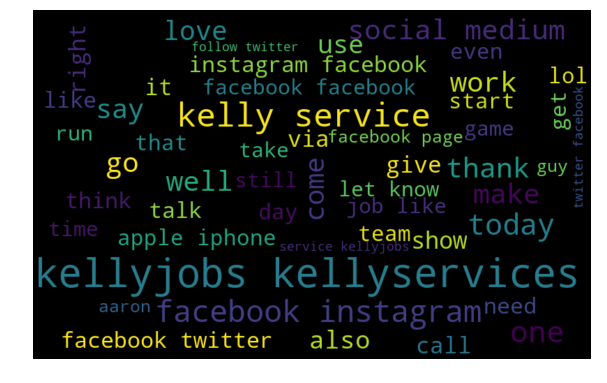

In [34]:
# https://www.datacamp.com/community/tutorials/wordcloud-python
import matplotlib.pyplot as plt 

all_words = ' '.join([text for text in lemma_df['full_text']])
add_stopwords = set()
add_stopwords.update(['amp', 'link', 'bio'])
from wordcloud import WordCloud
wordcloud = WordCloud(stopwords=add_stopwords, width=800, height=500, random_state=21, max_font_size=110, max_words=50).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

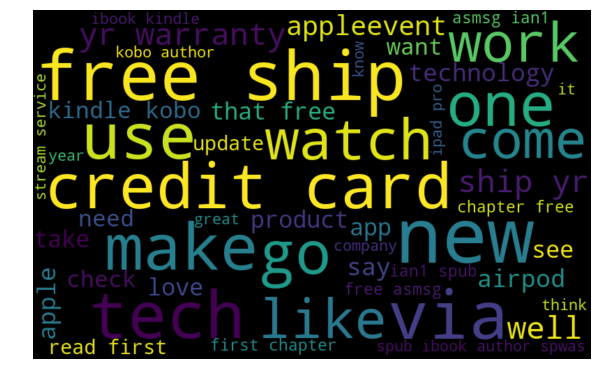

In [35]:
all_words = ' '.join([text for text in lemma_df[lemma_df['Symbol']=="AAPL"]['full_text']])
add_stopwords = set()
add_stopwords.update(['apple', 'iphone', 'amp', 'today', 'macbook', 'ipod','airpod', 'iartg', 'get'])
wordcloud = WordCloud(stopwords=add_stopwords, width=800, height=500, random_state=21, max_font_size=110, max_words=50).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

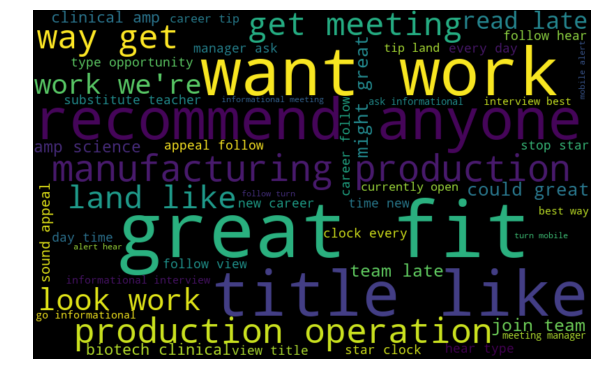

In [36]:
all_words = ' '.join([text for text in lemma_df[lemma_df['Symbol']=="KELYA"]['full_text']])
add_stopwords = set()
add_stopwords.update(['kelly', 'service', 'job', 'apply', 'kellyjobs', 'kellyservices', 'link', 'bio', 'hire', 'see', 'click', 'opening'])
wordcloud = WordCloud(stopwords=add_stopwords, width=800, height=500, random_state=21, max_font_size=110, max_words=50).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## ** Performing Sentiment Analysis**

In [37]:
lemma_df['full_text'].head()

2    altaba inc aaba pricier vmware inc vmw cheap post analyst                                                                                                                                                              
1    georgesoros big investment gciliberty coupasoftware philipmorris isharesrussell1000etf financial select sector spdrfund mondelezinternational altaba caesar entertainment vici property liberty broadband qanon wwg1wga
0    altaba aaba bidaskscore increase held                                                                                                                                                                                  
6    hedgefund manager paulsinger's elliottmanagement top sale q42018 altaba inc aaba                                                                                                                                       
8    hedgefund manager paulsinger's elliottmanagement top sale q42018 altaba inc aaba                               

In [0]:
sentiment_df = lemma_df.copy(deep=True)

In [0]:
def get_tweet_sentiment(tweet): 
        ''' 
        Function to classify sentiment of passed tweet using textblob's sentiment method 
        '''
        # create TextBlob object of passed tweet text 
        analysis = TextBlob(tweet) 
        return(analysis.sentiment.polarity)
#         set sentiment 
#         if analysis.sentiment.polarity > 0: 
#             return 'positive'
#         elif analysis.sentiment.polarity == 0: 
#             return 'neutral'
#         else: 
#             return 'negative'

In [0]:
from textblob import TextBlob 
sentiment_df['sentiment_value'] = sentiment_df['full_text'].apply(lambda x: get_tweet_sentiment(x))

In [0]:
# Create new date column
sentiment_df['date'] = sentiment_df['created_at'].dt.date

# Create new sentiment_value column
conditions = [
    (sentiment_df['sentiment_value'] > 0),
    (sentiment_df['sentiment_value'] == 0),
    (sentiment_df['sentiment_value'] < 0)]
choices = ["positive", "neutral", "negative"]
sentiment_df['sentiment'] = np.select(conditions, choices)

# Create new avg_sentiment_value_by_date column
avg_sentiment_value = sentiment_df.groupby('date', as_index=False).agg({'sentiment_value': 'mean'})
values_dict = avg_sentiment_value.set_index('date')['sentiment_value'].to_dict()
sentiment_df['avg_sentiment_value_by_date'] = sentiment_df['date'].map(values_dict)

# sorted_tweets_data['avg_sentiment_value_by_date'] = avg_sentiment_value

In [42]:
print(min(sentiment_df['avg_sentiment_value_by_date']))
print(max(sentiment_df['avg_sentiment_value_by_date']))

0.08013514125009011
0.11264415334064337


In [43]:
sentiment_df.Symbol.unique()

array(['AABA', 'AAN', 'AAOI', 'AAPL', 'ACIA', 'ACIW', 'ACLS', 'ADBE',
       'ADI', 'ADP', 'ADSK', 'AER', 'AEYE', 'AGYS', 'AIRG', 'AL', 'ALLT',
       'ALOT', 'ALTR', 'ALYA', 'AMAT', 'AMBA', 'AMBR', 'AMCN', 'AMD',
       'AMKR', 'AMN', 'AMRH', 'AMRHW', 'AMSWA', 'ANET', 'ANSS', 'ANY',
       'APPF', 'APPN', 'APY', 'AQ', 'ASML', 'ASX', 'ATEN', 'ATHM', 'ATOM',
       'ATTU', 'ATU', 'ATVI', 'AUO', 'AUTO', 'AVGO', 'AVID', 'AVLR',
       'AVNW', 'AWRE', 'AYR', 'AYX', 'BAND', 'BB', 'BCOV', 'BDR', 'BHE',
       'BIDU', 'BILI', 'BITA', 'BKI', 'BKTI', 'BL', 'BLIN', 'BLKB',
       'BNFT', 'BOX', 'BVSN', 'CACI', 'CAI', 'CAMP', 'CANG', 'CARB',
       'CARG', 'CARS', 'CASA', 'CBLK', 'CCNI', 'CCRN', 'CDAY', 'CDLX',
       'CERN', 'CEVA', 'CHKP', 'CISN', 'CLDR', 'CLGX', 'CLS', 'CMCM',
       'CMTL', 'CNET', 'COMM', 'COUP', 'CPSI', 'CRAY', 'CREE', 'CREX',
       'CREXW', 'CRM', 'CRUS', 'CSCO', 'CSIQ', 'CSOD', 'CSPI', 'CTG',
       'CTS', 'CTXS', 'CVR', 'CW', 'CY', 'CYBR', 'CYOU', 'CYRN', 'DATA',
      

## **Analysing results**

 Analysis of tweets sentiment results 
 
 Plot 1 - Stock Closing Price
 
 Plot 2 - Avg Sentiment VS Current Stock Price 
 
 Plot 3 - Pos-Neg Sentiment Ratio VS Current Stock Price

In [44]:
# Selected Stock Symbol for Plots:

curr_symbol = 'AAPL' # "KELYA", "MSFT", "AAPL"

curr_tweets = sentiment_df[sentiment_df['Symbol']==curr_symbol]
curr_tweets.head()


,Symbol,created_at,full_text,sentiment_value,date,sentiment,avg_sentiment_value_by_date
17529,AAPL,2019-02-15 13:33:20,new music stream platform newmusicalert newmusicfriday music hiphopmusic bestsong hiphop spotify apple tidal youtube friday,0.136364,2019-02-15,positive,0.112644
17528,AAPL,2019-02-15 13:40:13,apple release 2018 conflict mineral report remains 'deeply committed' responsible source apple,0.100000,2019-02-15,positive,0.112644
17527,AAPL,2019-02-15 13:50:04,review whitestone dome glass iphone x great screen protector w/ unique installation process iphonexsmax apple whitestonedomeglass,0.587500,2019-02-15,positive,0.112644
17526,AAPL,2019-02-15 14:10:34,sarah choice book series get apple asmsg spub ian1 iartg scifi,0.000000,2019-02-15,neutral,0.112644
17525,AAPL,2019-02-15 14:13:19,anyone else notice horrible battery drain upgrade io 12 wow it’s terrible apple iphone,-0.633333,2019-02-15,negative,0.112644


In [45]:
# Most positive tweets  
print("Most Positive Tweets")
print(curr_tweets.sort_values(['sentiment_value'], ascending=[0])['full_text'].head())

print('\n')
print("Most negative tweets")
print(curr_tweets.sort_values(['sentiment_value'], ascending=[0])['full_text'].tail())

Most Positive Tweets
1204     get best deal set apple wireless earbuds get freeshipping chance save everything apple                                                     
16593    forex best profit signal 10x gain join telegram paypal jpy nyse iwm usd qqq aud portfolio amazon eth gbp nasdaq spy apple cad tlt 152539825
73001    apple android what's really best                                                                                                           
58883    get best fitness movement data apple watch applewatch applewatchs4 applewatchseries4 apple tutorial tutorial technology                    
80694    forex best profit signal 10x gain join telegram portfolio iwm cad amazon paypal apple eth qqq nyse jpy spy tlt gbp nasdaq aud usd 145996699
Name: full_text, dtype: object


Most negative tweets
62105    don’t trust &amp since apple goldmansachs &amp mastercard business ruthlessly make money doesn’t make sense                                    
69444    airpods probably t

In [46]:
default_fig_size = plt.rcParams["figure.figsize"]
default_fig_size

[6.0, 4.0]

In [0]:
import pandas as pd
from pandas_datareader import data as pdr
import fix_yahoo_finance
import os

In [0]:
# Scrape current symbol's stock data from Yahoo Finance
curr_scraped_data = pdr.get_data_yahoo(curr_symbol, start='2019-02-10', end='2019-04-01')
curr_scraped_data = curr_scraped_data.reset_index()

# data.to_csv(directory+currSymbol+'_unseen.csv')

In [49]:
print(curr_symbol)
print(curr_scraped_data.head())
print('\n')
print(curr_scraped_data.tail())

AAPL
        Date        High         Low        Open       Close    Volume   Adj Close
0 2019-02-11  171.210007  169.250000  171.050003  169.429993  20993400  169.429993
1 2019-02-12  171.000000  169.699997  170.100006  170.889999  22283500  170.889999
2 2019-02-13  172.479996  169.919998  171.389999  170.179993  22490200  170.179993
3 2019-02-14  171.259995  169.380005  169.710007  170.800003  21835700  170.800003
4 2019-02-15  171.699997  169.750000  171.250000  170.419998  24626800  170.419998


         Date        High         Low        Open       Close    Volume   Adj Close
30 2019-03-26  192.880005  184.580002  191.660004  186.789993  49800500  186.789993
31 2019-03-27  189.759995  186.550003  188.750000  188.470001  29848400  188.470001
32 2019-03-28  189.559998  187.529999  188.949997  188.720001  20780400  188.720001
33 2019-03-29  190.080002  188.539993  189.830002  189.949997  23564000  189.949997
34 2019-04-01  191.679993  188.380005  191.639999  191.240005  27862000  19

Text(0.5, 1.0, 'AAPL Closing Stock Price')

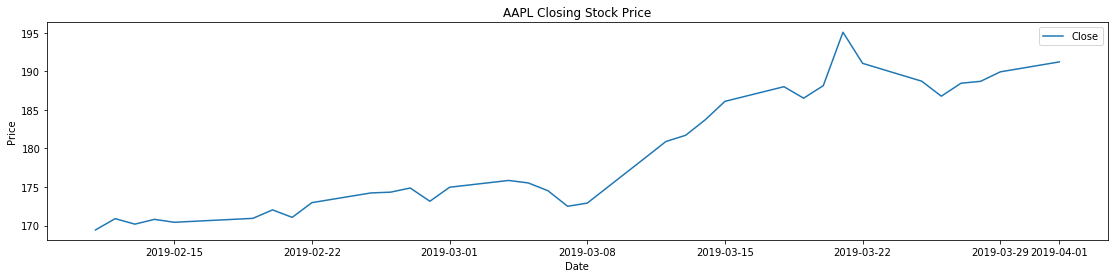

In [50]:
plt.figure(figsize=(19,4))
plt.plot(curr_scraped_data['Date'], curr_scraped_data['Close'])

plt.ylabel("Price")
plt.xlabel("Date")
plt.legend(["Close"])
plt.title(curr_symbol + " Closing Stock Price")

In [0]:
from sklearn.preprocessing import MinMaxScaler

# Function to normalise data
def scale_df(data, lower_bound, upper_bound):
  # reshape the data
  data = data.values.reshape(-1,1)
  sc = MinMaxScaler(feature_range=(lower_bound,upper_bound))
  return sc.fit_transform(data) 

In [52]:
# Scale up average tweet sentiments to MinMax of Stock price  
curr_tweets['avg_sentiment_value_by_date'] = scale_df(curr_tweets['avg_sentiment_value_by_date'], min(curr_scraped_data['Close']), max(curr_scraped_data['Close']))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [53]:
print(curr_tweets.shape)
print(curr_tweets.head())
print('\n')
print(curr_tweets.tail())


(65852, 7)
      Symbol          created_at                                                                                                                          full_text  sentiment_value        date sentiment  avg_sentiment_value_by_date
17529  AAPL  2019-02-15 13:33:20  new music stream platform newmusicalert newmusicfriday music hiphopmusic bestsong hiphop spotify apple tidal youtube friday        0.136364         2019-02-15  positive  195.089996                 
17528  AAPL  2019-02-15 13:40:13  apple release 2018 conflict mineral report remains 'deeply committed' responsible source apple                                     0.100000         2019-02-15  positive  195.089996                 
17527  AAPL  2019-02-15 13:50:04  review whitestone dome glass iphone x great screen protector w/ unique installation process iphonexsmax apple whitestonedomeglass  0.587500         2019-02-15  positive  195.089996                 
17526  AAPL  2019-02-15 14:10:34  sarah choice book series ge

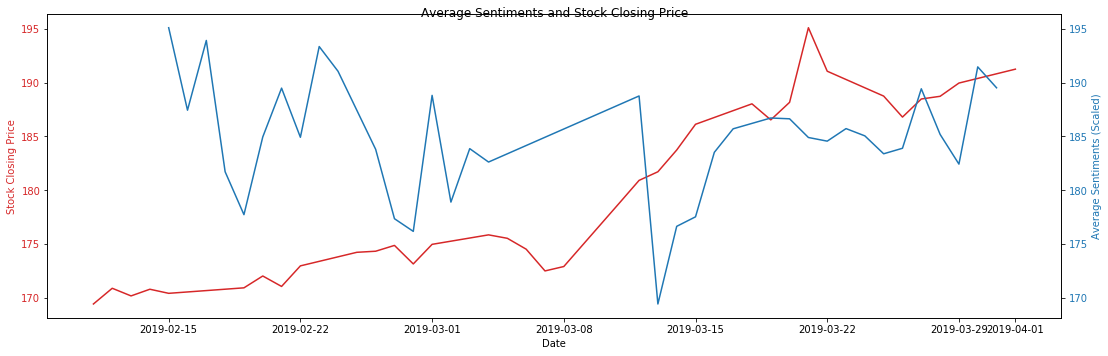

In [54]:
fig, ax1 = plt.subplots()
fig.set_size_inches(15.5, 5)

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Stock Closing Price', color=color)
ax1.plot(curr_scraped_data['Date'],curr_scraped_data['Close'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Average Sentiments (Scaled)', color=color)  # we already handled the x-label with ax1
ax2.plot(curr_tweets['date'], curr_tweets['avg_sentiment_value_by_date'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.suptitle("Average Sentiments and Stock Closing Price")
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [55]:
# Count the number of positive, neutral and negative sentiments respectively 
senti_count_df = pd.DataFrame({'sentiment_count': curr_tweets.groupby(['date', 'sentiment'])['sentiment'].count()}).reset_index()
print(senti_count_df.shape)
print(senti_count_df.head())

(108, 3)
         date sentiment  sentiment_count
0  2019-02-15  negative  89             
1  2019-02-15  neutral   188            
2  2019-02-15  positive  219            
3  2019-02-16  negative  189            
4  2019-02-16  neutral   499            


In [75]:
# Pivot data to have each row with unique date
pivot_df = senti_count_df.pivot('date', 'sentiment', 'sentiment_count').fillna(0).reset_index()
print(senti_count_df.shape)
print(pivot_df.head())

(108, 3)
sentiment        date  negative  neutral  positive
0          2019-02-15  89        188      219     
1          2019-02-16  189       499      559     
2          2019-02-17  157       435      570     
3          2019-02-18  214       720      840     
4          2019-02-19  231       708      745     


In [76]:
# Calculates positive-to-negative sentiment ratio for each date
curr_wide_df = pd.DataFrame({'date': pivot_df['date']})
curr_wide_df['pos_neg_ratio'] = np.where(pivot_df['negative']==0, pivot_df['positive'], pivot_df['positive']/pivot_df['negative'])

print(curr_wide_df.shape)
print(curr_wide_df.head())

(36, 2)
         date  pos_neg_ratio
0  2019-02-15  2.460674     
1  2019-02-16  2.957672     
2  2019-02-17  3.630573     
3  2019-02-18  3.925234     
4  2019-02-19  3.225108     


In [77]:
print(min(curr_wide_df['pos_neg_ratio']))
print(max(curr_wide_df['pos_neg_ratio']))

2.0680473372781063
4.411255411255412


In [78]:
# Scales positive-to-negative sentiment ratio to MinMax of stock closing price
curr_wide_df['pos_neg_ratio'] = scale_df(curr_wide_df['pos_neg_ratio'], min(curr_scraped_data['Close']), max(curr_scraped_data['Close']))

print(min(curr_wide_df['pos_neg_ratio']))
print(max(curr_wide_df['pos_neg_ratio']))

169.42999267578125
195.08999633789062


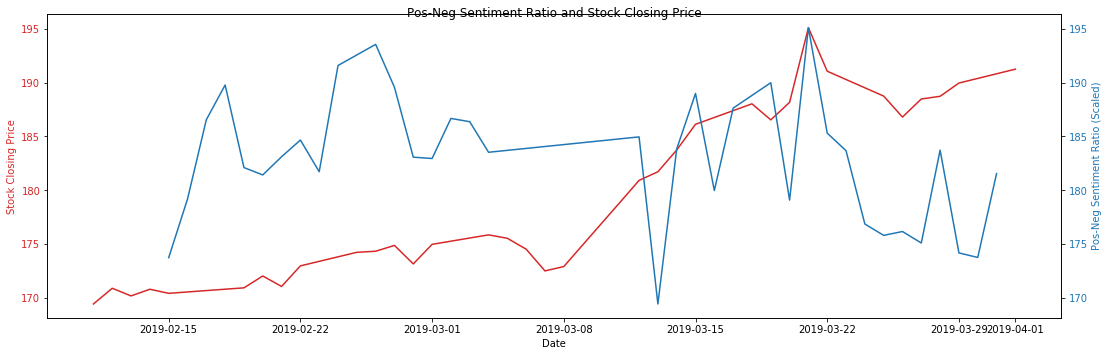

In [79]:
fig, ax1 = plt.subplots()
fig.set_size_inches(15.5, 5)

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Stock Closing Price', color=color)
ax1.plot(curr_scraped_data['Date'],curr_scraped_data['Close'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Pos-Neg Sentiment Ratio (Scaled)', color=color)  # we already handled the x-label with ax1
ax2.plot(curr_wide_df['date'], curr_wide_df['pos_neg_ratio'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.suptitle("Pos-Neg Sentiment Ratio and Stock Closing Price")
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [0]:
# pd.reset_option('display.max_columns', None)  
# pd.reset_option('display.expand_frame_repr', False)
# pd.reset_option('max_colwidth', -1)